In [1]:
import tensorflow as tf
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import scipy.ndimage.interpolation as sni
from time import time

%matplotlib inline

C:\Users\snuist\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train = io.imread("image1.jpg")
print(X_train.shape)
# X_train = X_train[:796, :, :][:, :960, :] # Trim size
X_train = rgb2lab(X_train)[:, :, [0]]

H, W, _ = X_train.shape
X_train = X_train.reshape((1, H, W, 1))
print(H, W)

(340, 300, 3)
340 300


In [3]:
batch_size = 1
Q = 313
T = 0.38

N = batch_size

In [4]:
X = tf.placeholder(tf.float32, [N, H, W, 1], name='X')

# def weight_variable(shape, name=None):
#     # Try K-mean initializers
#     initial = tf.truncated_normal(shape, stddev=0.1)
#     return tf.Variable(initial, name=name)

# def bias_variable(shape, name=None):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.Variable(initial, name=name)

def conv2d(x, W, stride=1, dilation=1, name=None):
    strides = [1, stride, stride, 1]
    dilations = [1, 1, dilation, dilation]
    return tf.nn.conv2d(x, W, padding="SAME", strides=strides, dilations=dilations, name=name)

def conv2d_T(x, W, output_shape, stride=1, name=None):
    strides = [1, stride, stride, 1]
    return tf.nn.conv2d_transpose(x, W, output_shape=output_shape, strides=strides, name=name)

def batch_normalize(x, batch_mean, batch_var, shape, epsilon=1e-3, name=None):
    beta = tf.Variable(tf.zeros(shape))
    scale = tf.Variable(tf.ones(shape))
    return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, scale, epsilon, name=name)

In [5]:
par = np.load("v1.npy", encoding='latin1') #
################################################################
W_conv1_1 = par.all()['bw_conv1_1']['weights']
b_conv1_1 = par.all()['bw_conv1_1']['biases']
conv1_1 = conv2d(X, W_conv1_1) + b_conv1_1
conv1_1 = tf.nn.relu(conv1_1)

W_conv1_2 = par.all()['conv1_2']['weights']
b_conv1_2 = par.all()['conv1_2']['biases']
conv1_2 = conv2d(conv1_1, W_conv1_2, stride=2) + b_conv1_2
conv1_2 = tf.nn.relu(conv1_2)

conv1_mean = par.all()['conv1_2norm']['mean']
conv1_var = par.all()['conv1_2norm']['variance']
conv1_norm = batch_normalize(conv1_2, conv1_mean, conv1_var, [64])
################################################################
W_conv2_1 = par.all()['conv2_1']['weights']
b_conv2_1 = par.all()['conv2_1']['biases']
conv2_1 = conv2d(conv1_norm, W_conv2_1) + b_conv2_1
conv2_1 = tf.nn.relu(conv2_1)

W_conv2_2 = par.all()['conv2_2']['weights']
b_conv2_2 = par.all()['conv2_2']['biases']
conv2_2 = conv2d(conv2_1, W_conv2_2, stride=2) + b_conv2_2
conv2_2 = tf.nn.relu(conv2_2)

conv2_mean = par.all()['conv2_2norm']['mean']
conv2_var = par.all()['conv2_2norm']['variance']
conv2_norm = batch_normalize(conv2_2, conv2_mean, conv2_var, [128])
################################################################
W_conv3_1 = par.all()['conv3_1']['weights']
b_conv3_1 = par.all()['conv3_1']['biases']
conv3_1 = conv2d(conv2_norm, W_conv3_1) + b_conv3_1
conv3_1 = tf.nn.relu(conv3_1)

W_conv3_2 = par.all()['conv3_2']['weights']
b_conv3_2 = par.all()['conv3_2']['biases']
conv3_2 = conv2d(conv3_1, W_conv3_2) + b_conv3_2
conv3_2 = tf.nn.relu(conv3_2)

W_conv3_3 = par.all()['conv3_3']['weights']
b_conv3_3 = par.all()['conv3_3']['biases']
conv3_3 = conv2d(conv3_2, W_conv3_3, stride=2) + b_conv3_3
conv3_3 = tf.nn.relu(conv3_3)

conv3_mean = par.all()['conv3_3norm']['mean']
conv3_var = par.all()['conv3_3norm']['variance']
conv3_norm = batch_normalize(conv3_3, conv3_mean, conv3_var, [256])
################################################################
W_conv4_1 = par.all()['conv4_1']['weights']
b_conv4_1 = par.all()['conv4_1']['biases']
conv4_1 = conv2d(conv3_norm, W_conv4_1) + b_conv4_1
conv4_1 = tf.nn.relu(conv4_1)

W_conv4_2 = par.all()['conv4_2']['weights']
b_conv4_2 = par.all()['conv4_2']['biases']
conv4_2 = conv2d(conv4_1, W_conv4_2) + b_conv4_2
conv4_2 = tf.nn.relu(conv4_2)

W_conv4_3 = par.all()['conv4_3']['weights']
b_conv4_3 = par.all()['conv4_3']['biases']
conv4_3 = conv2d(conv4_2, W_conv4_3) + b_conv4_3
conv4_3 = tf.nn.relu(conv4_3)

conv4_mean = par.all()['conv4_3norm']['mean']
conv4_var = par.all()['conv4_3norm']['variance']
conv4_norm = batch_normalize(conv4_3, conv4_mean, conv4_var, [512])
################################################################
W_conv5_1 = par.all()['conv5_1']['weights']
b_conv5_1 = par.all()['conv5_1']['biases']
conv5_1 = conv2d(conv4_norm, W_conv5_1, dilation=2) + b_conv5_1
conv5_1 = tf.nn.relu(conv5_1)

W_conv5_2 = par.all()['conv5_2']['weights']
b_conv5_2 = par.all()['conv5_2']['biases']
conv5_2 = conv2d(conv5_1, W_conv5_2, dilation=2) + b_conv5_2
conv5_2 = tf.nn.relu(conv5_2)

W_conv5_3 = par.all()['conv5_3']['weights']
b_conv5_3 = par.all()['conv5_3']['biases']
conv5_3 = conv2d(conv5_2, W_conv5_3, dilation=2) + b_conv5_3
conv5_3 = tf.nn.relu(conv5_3)

conv5_mean = par.all()['conv5_3norm']['mean']
conv5_var = par.all()['conv5_3norm']['variance']
conv5_norm = batch_normalize(conv5_3, conv5_mean, conv5_var, [512])
################################################################
W_conv6_1 = par.all()['conv6_1']['weights']
b_conv6_1 = par.all()['conv6_1']['biases']
conv6_1 = conv2d(conv5_norm, W_conv6_1, dilation=2) + b_conv6_1
conv6_1 = tf.nn.relu(conv6_1)

W_conv6_2 = par.all()['conv6_2']['weights']
b_conv6_2 = par.all()['conv6_2']['biases']
conv6_2 = conv2d(conv6_1, W_conv6_2, dilation=2) + b_conv6_2
conv6_2 = tf.nn.relu(conv6_2)

W_conv6_3 = par.all()['conv6_3']['weights']
b_conv6_3 = par.all()['conv6_3']['biases']
conv6_3 = conv2d(conv6_2, W_conv6_3, dilation=2) + b_conv6_3
conv6_3 = tf.nn.relu(conv6_3)

conv6_mean = par.all()['conv6_3norm']['mean']
conv6_var = par.all()['conv6_3norm']['variance']
conv6_norm = batch_normalize(conv6_3, conv6_mean, conv6_var, [512])
################################################################
W_conv7_1 = par.all()['conv7_1']['weights']
b_conv7_1 = par.all()['conv7_1']['biases']
conv7_1 = conv2d(conv6_norm, W_conv7_1) + b_conv7_1
conv7_1 = tf.nn.relu(conv7_1)

W_conv7_2 = par.all()['conv7_2']['weights']
b_conv7_2 = par.all()['conv7_2']['biases']
conv7_2 = conv2d(conv7_1, W_conv7_2) + b_conv7_2
conv7_2 = tf.nn.relu(conv7_2)

W_conv7_3 = par.all()['conv7_3']['weights']
b_conv7_3 = par.all()['conv7_3']['biases']
conv7_3 = conv2d(conv7_2, W_conv7_3) + b_conv7_3
conv7_3 = tf.nn.relu(conv7_3)

conv7_mean = par.all()['conv7_3norm']['mean']
conv7_var = par.all()['conv7_3norm']['variance']
conv7_norm = batch_normalize(conv7_3, conv7_mean, conv7_var, [512])
################################################################
W_conv8_1 = par.all()['conv8_1'][0].transpose((2, 3, 1, 0))
# W_conv8_1 = par.all()['conv8_1'][0].transpose((3, 2, 1, 0))
################################################################
b_conv8_1 = par.all()['conv8_1'][1]
conv8_1 = conv2d_T(conv7_norm, W_conv8_1, output_shape=[N, H//4, W//4, 256], stride=2) + b_conv8_1
conv8_1 = tf.nn.relu(conv8_1)

W_conv8_2 = par.all()['conv8_2']['weights']
b_conv8_2 = par.all()['conv8_2']['biases']
conv8_2 = conv2d(conv8_1, W_conv8_2) + b_conv8_2
conv8_2 = tf.nn.relu(conv8_2)

W_conv8_3 = par.all()['conv8_3']['weights']
b_conv8_3 = par.all()['conv8_3']['biases']
conv8_3 = conv2d(conv8_2, W_conv8_3) + b_conv8_3
conv8_3 = tf.nn.relu(conv8_3)

W_conv8_313 = par.all()['conv8_313']['weights']
b_conv8_313 = par.all()['conv8_313']['biases']
conv8_313 = conv2d(conv8_3, W_conv8_313) + b_conv8_313
################################################################
class8_313_rh = tf.nn.softmax(conv8_313 / 0.38)
################################################################
W_decode = par.all()['class8_ab']['weights']
b_decode = par.all()['class8_ab']['biases']
class8_ab = conv2d(class8_313_rh, W_decode) + b_decode

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_hat = sess.run(class8_ab, feed_dict={X: X_train - 50})

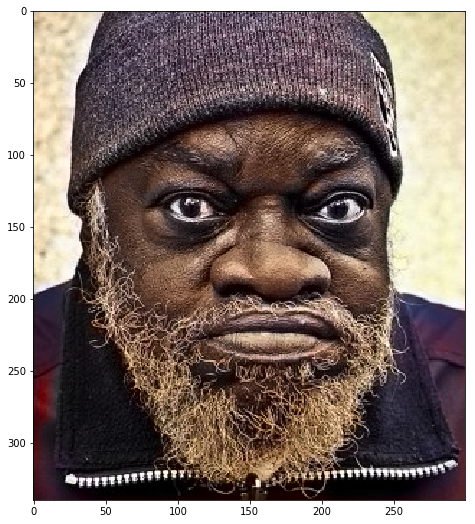

In [7]:
y_hat_up = sni.zoom(y_hat, (1, 4, 4, 1))

image_lab = np.zeros((N, H, W, 3))
image_lab[:, :, :, 0] = X_train[:, :, :, 0]
image_lab[:, :, :, 1:] = y_hat_up

image_rgb = np.zeros((*X_train.shape[:3], 3), dtype=np.uint8)
for i in range(N):
    image_rgb[i] = (255*lab2rgb(image_lab[i], )).astype(np.uint8)

figure = plt.figure(figsize=(12, 9))
plt.imshow(lab2rgb(image_lab[0]))
plt.show()